<a href="https://colab.research.google.com/github/mikaelangelm/scalping/blob/main/alpari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1) IMPORT LIBRARY**

In [30]:
#@title lib import 
from IPython.display import clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import sklearn as sl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt
#DONE import a model to train
# from sklearn.linear_model import perceptron
import numpy as np
#import dask.dataframe as dd #https://habr.com/ru/company/ruvds/blog/500428/ - multiprocessing
from bs4 import BeautifulSoup
import datetime

import tensorflow as tf
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

# import pandas_datareader as pdr #quotes = pdr.data.DataReader('GAZP', 'moex', start='2010-01-01', end='2010-01-02')
import pandas as pd
import requests # https://python-scripts.com/requests
import zipfile
import pandas as pd
import os

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    path = '/content/drive/MyDrive/Colab Notebooks/20201223_alpari/documents/'
except:
    path ='/documents/'

nan = float('nan')

!pip install gtts
from gtts import gTTS #Import Google Text to Speech
from IPython.display import Audio #Import Audio method from IPython's Display Class
clear_output()

In [31]:
#@title TG() telegram message
def ОтправитьСообщениеВТелеграм(Сообщение, Чат="322155227", parse_mode="Markdown", ДобавитьПодпись=False):
    try:
        if ДобавитьПодпись: # использовать с осторожностью, может и не сработать
            Сообщение = Сообщение + " (Отправлено из 1С)"
        ПокатитьНаТелеге = requests.get("https://api.telegram.org/bot1757275501:AAGLxZfmbxPX_u9LTNkBbUpttg3KWsloMfE/sendMessage?chat_id=" + Чат + "&text=" + Сообщение + "&parse_mode=" + parse_mode, timeout=(2, 5))        
        return ПокатитьНаТелеге.ok        
    except:
        print('f')
        return False

def TG(Сообщение, Чат="322155227", parse_mode="Markdown", ДобавитьПодпись=False):
    return ОтправитьСообщениеВТелеграм(Сообщение, Чат, parse_mode, ДобавитьПодпись)    

In [32]:
#@title TTS() audio message
# https://stackoverflow.com/questions/57563060/how-to-do-text-to-speech-conversion-in-google-colab
def tts(text='text to speech example'):
    tts = gTTS(text) #Provide the string to convert to speech
    tts.save('tts.wav') #save the string converted to speech as a .wav file
    sound_file = 'tts.wav'
    return sound_file # Audio(sound_file, autoplay=True) # DONE execute to play 

#Autoplay = True will play the sound automatically
#If you would not like to play the sound automatically, simply pass Autoplay = False.

In [33]:
#@title file class
class file:
    '''класс для работы с файлами курсов (tiks) и событий (event)
    '''
    def __init__(self, name=''):
        import os
        import pandas as pd
        from google.colab import files
        # if name != '':
        self.name = name
    def size(self, name: str='', prettify=True):
        name = name if name != '' else self.name
        return format(os.path.getsize(name) / 1024 / 1024, '.2f') + ' Mb' if prettify else os.path.getsize(name)
    def download(self, name: str=''):
        files.download(name if name != '' else self.name)
    def save(self, name: str='', key: str=''):
        if not isinstance(self.name, pd.DataFrame) and not isinstance(name, pd.DataFrame):
            raise ValueError('file must be a pandas.DataFrame')
        if key == '': key = name

        if isinstance(self.name, pd.DataFrame):
            df      = self.name
        elif isinstance(name, pd.DataFrame):
            df      = name
            name    = self.name
        
        if name.find('csv') != -1:
            df.to_csv(name, index=False)
        elif name.find('xls') != -1:
            df.to_excel(name, index=False)
        else:
            df.to_hdf(name, key, index=False)

    def read(self, name: str='', key: str=''):
        '''read a csv/xls/hdf by pandas
        '''
        if key == '': key = name
        try:
            if name.find('csv') != -1:
                return pd.read_csv(name, parse_dates=['date'])
            elif name.find('xls') != -1:
                return pd.read_excel(name, parse_dates=['date'])
            else:
                return pd.read_hdf(name, key, parse_dates=['date'])
        except:
            print('cannot read from file: ' + name)

In [34]:
#@title google hack
# to increase RAM 12 Gb -> 25 Gb
# https://towardsdatascience.com/upgrade-your-memory-on-google-colab-for-free-1b8b18e8791d
# a = []
# while(1):
#     a.append('1')

# **2) IMPORT&PREPARE TIKS&EVENTS**. [Skillbox: машинное обучение](https://live.skillbox.ru/?direction=code&search=машинно) ; [1 урок](https://colab.research.google.com/drive/1OTlwFbKpDD6R18TURcWzX_tJnLJPlUZG?usp=sharing) ; [2 урок (08.12)](https://colab.research.google.com/drive/1P6yPr5Oj4HnanNVVfqydBoB41kqvhflv?usp=sharing) ; [fxstreet.com](https://www.fxstreet.com/economic-calendar) [альтернативный календарь](https://www.kaggle.com/devorvant/economic-calendar)


## IMPORT. 

In [35]:
#@title get_quotes()
# IMPORT TIKS
# 
# http://ticks.alpari.org/
# params:
# from_file - str, DataFrame - file name or url to download from
# to_file   - str, DataFrame - file name to write/concat from_file to
def get_quotes(from_file=None, to_file=None, sep='\\t', from_date=None, to_date=None):
    '''Импортирует тики с сайта ticks.alpari.org за заданный промежуток времени, 
    кратный календарному месяцу. Склеивает файлы за месяц в один файл
    
     Параметры:
        * from_file (str): адрес сайта или имя файла загрузки
        * to_file (str, pandas.DataFrame): путь к файлу или датафрейм
        * from_date (date-like): дата начала загрузки (кратно месяцу)
        * to_date (date-like): дата начала загрузки (кратно месяцу)
        
    Возвращаемое значение:
        * dataframe (pandas.DataFrame): табличное представление событий'''

    try:
        dir(pd)
    except:
        raise 'pandas has to be imported as pd'

    is_url          = True if from_file.lower().find('http') >= 0 else False
    path            = '' #'/content/drive/'
    downloaded_file = path + 'quotes.zip'
 
    if is_url: 
        from bs4 import BeautifulSoup
        response = requests.get(from_file)

        # read 1 zip
        if response.headers["Content-Type"] == "application/zip": #e.g.: http://ticks.alpari.org/standard2/USDRUB/2021/202101_standard2_USDRUB.zip
            # write zip file from response.content
            # https://stackoverflow.com/questions/53101597/how-to-download-binary-file-using-requests
            with open(to_file if isinstance(to_file, str) else 'quotes.zip', 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024): 
                    if chunk: f.write(chunk) # filter out keep-alive new chunks            
                                         
            # read txt's from zip
            # https://stackoverflow.com/questions/44575251/reading-multiple-files-contained-in-a-zip-file-with-pandas  
            # to_df   = pd.concat([to_file, from_df]) if isinstance(to_file, pd.DataFrame) else None          
            from_df = pd.concat(
                [pd.read_csv(zipfile.ZipFile(downloaded_file).open(i), sep=sep, engine='python') for i in zipfile.ZipFile(downloaded_file).namelist()],
                ignore_index=True)
            return pd.concat([to_file, from_df], ignore_index=True) if isinstance(to_file, pd.DataFrame) else from_df
        
        # read many (<=12) zip
        elif response.headers["Content-Type"] == "text/html": # html with links to monthly zip, e.g.: http://ticks.alpari.org/standard2/USDRUB/2021/
            soup        = BeautifulSoup(response.content, 'lxml') # https://python-scripts.com/beautifulsoup-html-parsing#html-example 
            for url in [e.text for e in soup.pre.children if e.name is not None]:
                if url.find('.zip') != -1:
                    to_file = get_quotes(from_file + url, to_file) 
            return to_file   
    


    else:
        if from_file.lower().find('zip'):
            return pd.concat(
                [pd.read_csv(zipfile.ZipFile(from_file).open(i), sep='\\t') for i in zipfile.ZipFile(from_file).namelist()],
                ignore_index=True)
        else:            
            return pd.read_csv(from_file)


In [36]:
#@title get_events()
# IMPORT EVENTS: https://www.fxstreet.com/economic-calendar
def get_events(year=None, from_file: str='', country: list=[], currency: list=[], try_rename_columns=True):
    '''Импортирует события с сайта fxstreet.com/economic-calendar, 
    предварительно сохраненные за заданный промежуток времени в html.
    
    Параметры:
        * country (list-like): список строк Стран (см. файл)
        * currency (list-like): список строк Валют (см. файл)

    Возвращаемое значение:
        * fxs_df (pandas.DataFrame): табличное представление событий'''

    fxs_df  = pd.read_html(from_file)[0]

    soup    = BeautifulSoup(open(from_file))
    table   = soup.find('table', {'class': 'fxs_c_table'})
    # print(table.prettify())


    # COLUMNS processing. DONT delete, might be useful (instead of pd.read_html)
    # 0 Время 1 Влияние 2 Факт. 3 Откл. Отклонение: расхождение фактического зн. и консенсус-прогноза. [-7, +7] 4 Прогн. 5 Пред.
    # th = table.find_all('th', {'class': 'fxs_c_item '})
    # for column in th: if column != '': fxs_df[column.text] = ''
    # fxs_df.columns[[3]] = 'Откл.'; fxs_df = fxs_df.iloc[0:-2]

    if try_rename_columns: #20220131 ['Time', 'Event', 'Event.1', 'Event.2', 'Impact', 'Actual', 'DevDeviation', 'Consensus', 'Previous', 'Unnamed: 9', 'Unnamed: 10']
        try: fxs_df.columns  =  ['time', '_drop', 'currency', 'event', 'impact', 'actual', 'deviation', 'consensus', 'previous', 'date', 'flag'] # ['time', 'flag', 'currency', 'name', 'impact', 'actual', 'deviation', 'consensus', 'previous', 'dashboard']
        except: pass

    try:
        fxs_df.impact   = fxs_df.impact.astype(str, copy=False)
        fxs_df['date']  = pd.to_datetime(str(year) + ' ' + fxs_df.time, format="%Y %A, %B %d", errors='coerce') # 2021 sunday, august 1 #https://www.dataindependent.com/pandas/pandas-to-datetime/
        fxs_df.time.fillna('00:00', inplace=True)
        fxs_df.date.fillna(method='ffill', inplace=True)

        # ROWS processing
        impact_dict = {"['fxs_c_impact-icon', 'fxs_c_impact-none']":    0, 
                    "['fxs_c_impact-icon', 'fxs_c_impact-low']":     1, 
                    "['fxs_c_impact-icon', 'fxs_c_impact-medium']":  2, 
                    "['fxs_c_impact-icon', 'fxs_c_impact-high']":    3}

        c = 0
        for e in table.find('tbody'): 
            # unexpectable (new/edited) row
            if e.name != 'tr':
                print(e)
                raise 'not only table rows'        
            # table dates
            elif e.attrs == {}:
                pass
            # event. fill flag=country&impact cause they not filled py pd.read_html  
            else: # if e.attrs != {}:        
                fxs_df.loc[c, 'flag']   = e.find('td', {'class': 'fxs_c_item fxs_c_flag'})  .find('span').get('title')
                fxs_df.loc[c, 'impact'] = impact_dict[str(e.find('td', {'class': 'fxs_c_item fxs_c_impact'}).find('span').get('class'))]            
            c += 1

        fxs_df.impact   = pd.to_numeric(fxs_df.impact, errors='coerce').fillna(-1).astype(int)  # impact scale (see pic. below)
        fxs_df.drop(fxs_df[fxs_df['impact']==-1].index, axis=0, inplace=True)                   # drop extra row=date row
        time_serie       = pd.to_timedelta(fxs_df.time + ":00", #np.where(time_str.find("'") = -1, fxs_df.time + ":00", "00:00:00"),
                                        unit='sec',
                                        errors='coerce') \
                            .fillna(method='ffill')         
        fxs_df.date     = fxs_df.date + time_serie # fxs_df.time.apply(lambda _: pd.Timedelta(str(_) + ":00")) # date column to datetime column
        fxs_df.drop(['time', '_drop'], axis=1, inplace=True)                                               # drop extra time column
        fxs_df.previous = fxs_df.previous.str.replace('â¬', '€')                                # fix euro symbol
        fxs_df.actual   = fxs_df.actual  .str.replace('â¬', '€')
        fxs_df.previous = fxs_df.previous.str.replace('Â£-', '£')                                # fix pound symbol
        fxs_df.actual   = fxs_df.actual  .str.replace('Â£-', '£') 
        if len(currency) > 0: # https://ru.stackoverflow.com/questions/819147/Как-по-списку-значений-найти-вхождение-этих-значений-в-строки-в-датафрейме
            fxs_df = fxs_df[fxs_df['currency'].str.contains(r'\b(?:{})\b'.format('|'.join(currency)))] # contains currency only
        if len(country) > 0:
            fxs_df = fxs_df[fxs_df['flag']    .str.contains(r'\b(?:{})\b'.format('|'.join(country)))]  # contains country only

    except:
        print('Columns has changed! Processing crashed.') 

    return fxs_df                                                                           # return df

In [37]:
#IMPORT TIKS: дата, покупка, продажа 
#https://stackoverflow.com/questions/23797491/parse-dates-in-pandas
#https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/09_timeseries.html?highlight=parse_dates
#https://askdev.ru/q/kak-ukazat-format-daty-pri-ispolzovanii-pandas-v-csv-79821/
#date_parser = lambda dates: [dt.datetime.strptime(x, '%Y-%m-%d %HH:%MM:%SS.%n) for x in dates] 
# tiks = pd.read_csv(documents_path + 'standard2_EURUSD_2020.txt', names=['date', 'bid', 'ask'], parse_dates=['date'], nrows=20, sep='\t', skiprows=1, header=None) #pd.to_datetime(ticks.date, format="%Y-%m-%d %HH:%MM:%SS.%n")
try:
    %time _tiks = file().read(path+'tiks.csv')
except:
    _tiks = None

if not isinstance(_tiks, pd.DataFrame):
    _tiks, year_list = None, ['2021']
    for year in year_list:
        _tiks = (get_quotes(f'http://ticks.alpari.org/standard2/USDRUB/{year}/') if _tiks==None else    
                pd.concat([_tiks, get_quotes(f"http://ticks.alpari.org/standard2/USDRUB/{year}/")], ignore_index=True))
    TG(f'quotes for {str(year_list)} downloaded')
    # format(os.path.getsize('USDRUB.csv') / 1024 / 1024, '.0f') + ' Mb'
    _tiks.columns    = ['date', 'bid', 'ask']
    _tiks.date       = pd.to_datetime(_tiks.date)
    file(_tiks).save(path + 'tiks.csv')
    # DONE check is workable
    assert 0 < _tiks.date.dt.month.max() < 13
    assert _tiks.spread.min() > 0


CPU times: user 20.6 s, sys: 2.88 s, total: 23.5 s
Wall time: 31.3 s


In [39]:
#IMPORT EVENTS
#DONE грузануть события из https://www.fxstreet.ru.com/economic-calendar https://calendar-api.fxstreet.com/swagger/index.html
try:
    %time _events = file().read(path+'events.csv')
except:
    _events = None

if not isinstance(_events, pd.DataFrame):
    _events = get_events('2021', path + '2021 fxstreet.txt', try_rename_columns=True)
    file(_events).save(path + 'events.csv')

def color_deviation(cell):
    cell_numeric = pd.to_numeric(cell, errors='coerce')
    if cell_numeric != np.nan:
        return f"color: {'red' if cell_numeric < 0 else 'green'};"
    else:
        return 'color: white;'
# paint deviation 
# _=_events.style.applymap(color_deviation, subset='deviation')

CPU times: user 44.1 ms, sys: 0 ns, total: 44.1 ms
Wall time: 96.6 ms


## Описание данных событий

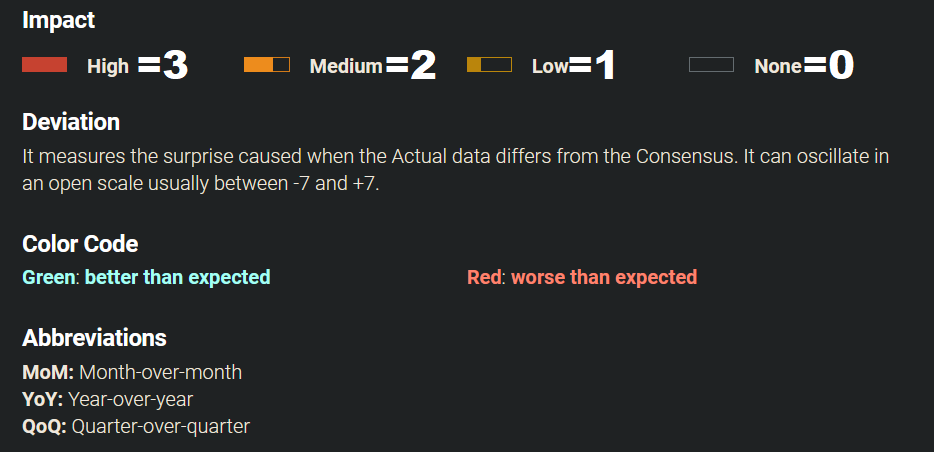

*   11 стран
*   Новый пункт

In [40]:
_events.describe(include='all', datetime_is_numeric=True)

,currency,event,impact,actual,deviation,consensus,previous,date,flag
count,8739,8739,8739.000000,8739,8739,8739,8739,8739,8739
unique,11,5353,NaN,3278,819,1493,4247,NaN,15
top,USD,10-y Bond Auction,NaN,Speech,-,-,Speech,NaN,United States
freq,2355,59,NaN,597,3191,3136,597,NaN,2355
mean,NaN,NaN,1.530839,NaN,NaN,NaN,NaN,2021-06-30 16:56:08.286989312,NaN
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,2021-01-01 05:00:00,NaN
25%,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,2021-03-31 06:00:00,NaN
50%,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,2021-06-29 13:00:00,NaN
75%,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,2021-10-01 06:15:00,NaN
max,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,2021-12-31 23:00:00,NaN


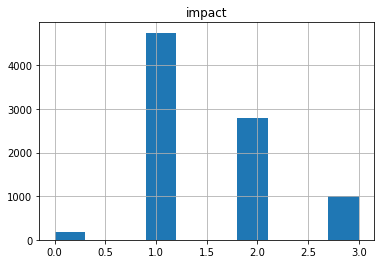

In [41]:
#title=f'распределение событий за {list(events.date.dt.year.unique())} год по важности')
ax = _events[['impact']].hist()

## PREPARE. [feature engeneering](https://habr.com/ru/company/vk/blog/346942/) ; 

In [42]:
def prepare_tiks(_tiks):
    # %%time
    # TIKS
    #MSD - среднеквадратичное отклонение = D**2 (квадрат дисперсии). STD - sqrt(PREV_STD_TIKS/(PREV_STD_TIKS-1))*D**2) за PREV_STD_TIKS последних тиков
    SHIFT_LIST      = [1000,10000,100000,500000]   # how far shift values of ask/bid to count profit 
    PREV_STD_TIKS   = 10000                 # это количество первых строк нужно будет дропнуть из учебника. previous N tiks to count std
    NEXT_SHIFT_TIKS = max(SHIFT_LIST)       # это количество строк должна содержать tiks
    FIRST           = len(_tiks) # max(1000000, NEXT_SHIFT_TIKS + PREV_STD_TIKS) # shouldn't be less than NEXT_SHIFT_TIKS + PREV_STD_TIKS
    assert len(_tiks) >= NEXT_SHIFT_TIKS + PREV_STD_TIKS, f"len(_tiks) should be >= {NEXT_SHIFT_TIKS + PREV_STD_TIKS}"

    tiks = _tiks.copy().head(FIRST)
    tiks.columns = ['date', 'bid', 'ask']
    #feature engeneering
    #https://ru.stackoverflow.com/questions/1223835/pandas-dataframe-Рассчитать-данные-произвольным-образом-из-численного-столбца-п/1223931#1223931
    #http://zabaykin.ru/?p=649 , https://habr.com/ru/company/ruvds/blog/500428/ - multiprocessing

    #days
    tiks['day_of_week'] = tiks.date.dt.dayofweek #-3.5
    tiks['minute']      = tiks.date.dt.minute / 60 - 0.5 
    tiks['hour']        = (tiks.date.dt.hour - 9) / 11 - 0.5 # TODO check is market works from 9 to 20 either fot USDRUB or any other 
    tiks['day']         = tiks.date.dt.day    / 31 - 0.5
    tiks['month']       = tiks.date.dt.month  / 12 - 0.5
    # TODO make a decise wether to delete 4 row below or no
    # tiks['days_in_month']     = tiks.date.dt.days_in_month
    # tiks['day_of_month_norm_0'] = tiks.day/tiks.date.dt.days_in_month - 0.5
    # tiks['year']        = tiks.date.dt.year
    # tiks.join(pd.get_dummies(tiks.date.dt.year))
    

    tiks['spread']      = tiks.ask - tiks.bid 
    # pd.get_dummies(tiks, columns=['day_of_week', 'month'])

    # standart deviation
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html?highlight=rolling#pandas.DataFrame.rolling 
    tiks['std']     = tiks.bid.shift(1).rolling(window=PREV_STD_TIKS).std()
    # shift to 10/100/1000/10000 in future values of ask/bid
    columns_list = []
    start_index  = len(tiks.columns)
    for price_type_open in ['ask', 'bid']: 
        operation             = 'buy' if price_type_open == 'ask' else 'sell'
        price_type_close      = 'bid' if price_type_open == 'ask' else 'ask' 
        for i in SHIFT_LIST:
            ORDER           = f"{operation}_{i}"
            tiks[ORDER]     = tiks[price_type_open] - tiks[price_type_close].shift(-i) if operation == 'sell' else - tiks[price_type_open] + tiks[price_type_close].shift(-i)  
            tiks.loc[tiks[ORDER] < 0, ORDER] = np.nan # replace negative profit to nan. Futher it will be equal to 'skip'
            columns_list.append(ORDER)        
            # break # DONE delete 2 break
        # break

    # drop unusable rows
    tiks.drop(index=list(range(0, PREV_STD_TIKS)),                inplace=True)
    tiks.drop(index=list(range(len(tiks) - NEXT_SHIFT_TIKS, -1)), inplace=True)
    tiks.reset_index(drop=True, inplace=True)

    # profit counting
    y           = tiks.iloc[:, start_index:start_index + len(columns_list)].idxmax(axis=1).fillna('skip') # DONE leave y = id or nan
    tiks        = tiks.join(y.to_frame())#.reset_index(drop=True))
    tiks.rename(columns={0: "y"}, inplace=True)

    # убедимся что почти все (меньше 1 ошибки на миллион) ДАТЫ ИДУТ ПО ВОЗРАСТАНИЮ = присоединения реализованы корректно
    # ошибка может присутствовать из за пограничных состояний закрытия/открытия торговой сессии кажый месяц 
    assert len(tiks[tiks.date > tiks.date.shift(-1)]) <= len(tiks) // 1000000

    tiks # 
    tiks.drop(columns=['date']+columns_list, inplace=True) #'days_in_month'
    tiks = pd.get_dummies(tiks.day_of_week).join(tiks)
    tiks.rename(columns={0: 'monday', 1: 'tuesday', 2: 'wednsday', 3: 'thursday', 4: 'friday'}, inplace=True)
    tiks.drop(columns='day_of_week', inplace=True)

    # TODO decide to cast to float or no
    # for column in tiks.columns: 
    #     if column != 'y':    
    #         tiks[column] = tiks[column].astype(float)

    # TODO or not to do
    # replace y str by y int
    # https://ru.stackoverflow.com/questions/690589/Смена-мест-между-ключами-и-их-значениями
    # target_dict          = dict(enumerate(columns_list))
    # target_dict[len(target_dict)] = 'skip'
    # target_dict_reversed = dict(reversed(item) for item in target_dict.items()) #{'buy_10': 0, 'buy_100': 1, ... , 'skip': N}
    # tiks.y               = tiks.y.apply(lambda y: target_dict_reversed[y], convert_dtype=True)
    # tiks                = tisk.join(pd.get_dummies(tiks.y))

    columns_list.append('skip')
    columns_dict = dict(enumerate(columns_list))

    return tiks, columns_dict

In [43]:
tiks, columns_dict = prepare_tiks(_tiks)

In [45]:
# EVENTS

def prepare_events(_events):
    if 'dashboard' in _events.columns.to_list() and len(_events.dashboard.unique()) == 1: 
        _events.drop(columns='dashboard', inplace=True)

    # 101 currency
    # 13  countrys: ['Australia', 'Canada', 'Switzerland', 'China', 'Italy', 'Spain', 'Germany', 'France', 'United Kingdom', 'Japan', 'New Zealand', 'Russia', 'United States']
    # 
    # 
    # len(_events.loc[_events['currency']=='RUB', 'name'])#.to_list()             # unique CURRENCY: 101
    # _events.drop_duplicates(['currency', 'impact']).sort_values(by='currency')  # unique CURRENCY&IMPACT
    # _events.groupby(['currency', 'impact']).sum()                   # groupby CURRENCY&IMPACT

    # _events[_events.name.str.contains('.*QoQ.*')]

    # _events.applymap(lambda _: 0 if _=='-' else _).applymap(lambda _: 0 if _=='All Day' else _)
    _events.applymap(lambda _: 0 if _=='-' else _)

    return _events

In [46]:
events = prepare_events(_events)

In [50]:
print('ТОРГОВЫЕ СОБЫТИЯ')
events.head(5)

print('ЦЕНЫ купли/продажи USDRUB')
tiks.head(5)

ТОРГОВЫЕ СОБЫТИЯ


,currency,event,impact,actual,deviation,consensus,previous,date,flag
0,USD,New Year's Day,0,All Day,All Day,All Day,All Day,2021-01-01 05:00:00,United States
1,CAD,New Year's Day,0,All Day,All Day,All Day,All Day,2021-01-01 05:00:00,Canada
2,NZD,Day after New Year's Day,0,All Day,All Day,All Day,All Day,2021-01-01 12:00:00,New Zealand
3,AUD,Commonwealth Bank Manufacturing PMI(Dec),1,55.7,-0.10,56,56,2021-01-03 22:00:00,Australia
4,JPY,Jibun Bank Manufacturing PMI(Dec),1,50,-,-,49.7,2021-01-04 00:45:00,Japan


ЦЕНЫ купли/продажи USDRUB


,monday,tuesday,wednsday,thursday,friday,bid,ask,minute,hour,day,month,spread,std,y
0,1,0,0,0,0,73.312,73.564,-0.25,-0.409091,-0.370968,-0.416667,0.252,0.240719,buy_100000
1,1,0,0,0,0,73.312,73.565,-0.25,-0.409091,-0.370968,-0.416667,0.253,0.240663,buy_100000
2,1,0,0,0,0,73.312,73.564,-0.25,-0.409091,-0.370968,-0.416667,0.252,0.240593,buy_100000
3,1,0,0,0,0,73.310,73.563,-0.25,-0.409091,-0.370968,-0.416667,0.253,0.240520,buy_100000
4,1,0,0,0,0,73.309,73.559,-0.25,-0.409091,-0.370968,-0.416667,0.250,0.240445,buy_100000


# **3) MODEL COMPILE**. [Losses](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy?hl=ru) ; [для самых маленьких](https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc) ; piplines ([1](https://habr.com/ru/company/skillbox/blog/444684/), [2](https://proglib.io/p/networks-debugging))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 13)                182       
                                                                 
 dense_14 (Dense)            (None, 26)                364       
                                                                 
 dense_15 (Dense)            (None, 9)                 243       
                                                                 
Total params: 789
Trainable params: 789
Non-trainable params: 0
_________________________________________________________________
СТРУКТУРА МОДЕЛИ ТОРГОВЛИ


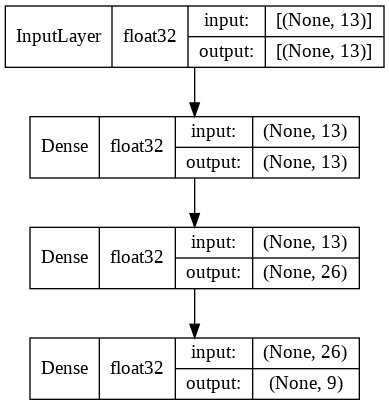

In [51]:
class Model(tf.keras.Model): 
    '''sequental subclassed tf.keras.Model'''
    def __init__(self, lr=0.01):
        super().__init__()  
        N_FEATURES  = len(tiks.columns) - 1  
        self.layers_list = []
        self.lr          = lr          
        self.input_layer = tf.keras.layers.Dense(N_FEATURES,    activation='sigmoid', input_shape=(N_FEATURES, ))
        self.layer1      = tf.keras.layers.Dense(N_FEATURES**2, activation='sigmoid')
        self.layer2      = tf.keras.layers.Dense(N_FEATURES*2,  activation='sigmoid')
        self.output_layer= tf.keras.layers.Dense(len(columns_dict), activation='softmax') 
        self.layers_list = [self.input_layer, self.layer1, self.layer2, self.output_layer]

    def __setattr__(self, name, value):
        super().__setattr__(name, value)
        if name.find('layer'):
            if getattr(self, 'layers_list', None)==None:                
                pass  
            else:
                self.layers_list.append(value)

    def call(self, FROM_LAYERS=1, N_LAYERS=-1):
        model            = tf.keras.Sequential([self.input_layer] + self.layers_list[FROM_LAYERS:N_LAYERS] + [self.output_layer])
        # https://www.tensorflow.org/api_docs/python/tf/keras/Model?hl=ru
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr),
                    loss      = tf.keras.losses.categorical_crossentropy,    # https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy?hl=ru
                    metrics   = tf.keras.metrics.Precision()                  # https://habr.com/ru/company/ods/blog/328372/
                    )
        return model
    

# %pdb off
model = Model().call(2)
model.summary()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print('СТРУКТУРА МОДЕЛИ ТОРГОВЛИ')
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=False)

# **4) MODEL [FIT](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)**. [Pipeline от skillbox](https://habr.com/ru/company/skillbox/blog/444684/) ; [Callbacks (1](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping), [2](https://ru-keras.com/callbacks/)) ; [тонкая настройка .fit](https://youtu.be/-u2OI_9HDiU?list=PLA0M1Bcd0w8ynD1umfubKq1OBYRXhXkmH&t=303) ; TODO проверить лосс [2.19](https://yandex.ru/search/?text=–ln+(1%2F9)) ; [tf.guide.fit](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit)

In [52]:
# Разделение и выборка части данных
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(tiks.iloc[::10, 0:-1],
#                                                     pd.get_dummies(tiks.y)[::10], #tiks.iloc[::100, -1],
#                                                     test_size=0.20,
#                                                     # random_state=42
#                                                     )

n_times_less    = 1
n               = -1
# n_times_less    = n_times_less if n == 0 else len(tiks) // n
# n               = n            if n > 0  else len(tiks) // n_times_less

# len(tiks.iloc[::n_times_less, 0:-1])
X = tiks.iloc[::n_times_less, 0:-1].head(n).values / 1.
y = pd.get_dummies(tiks.y)[::n_times_less].head(n).values#.argmax(axis=1) argmax - for sparse CCE
X.shape, y.shape
# X.dtypes

((14575568, 13), (14575568, 9))

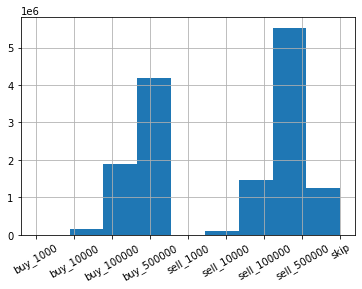

In [53]:
tiks.y.sort_values().hist(xrot=30, bins=9, align='mid')

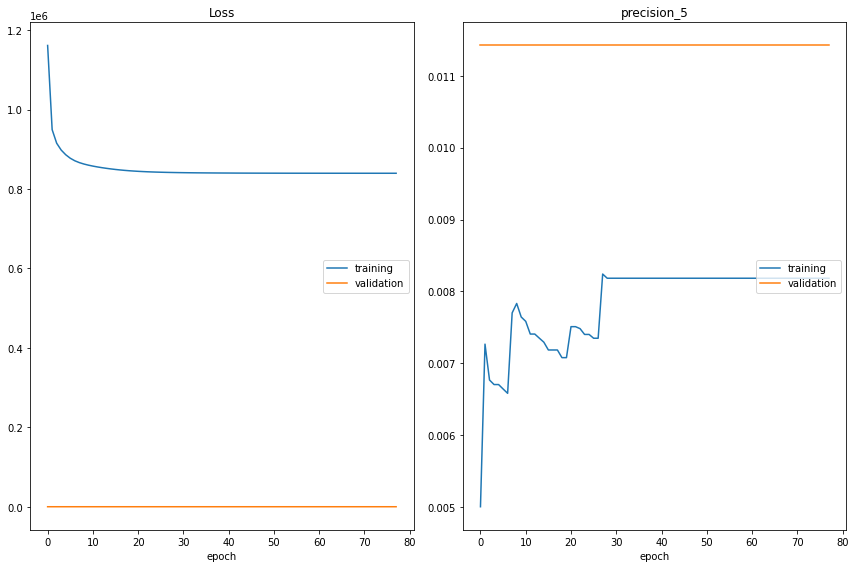

Loss
	training         	 (min: 839507.688, max: 1161225.750, cur: 839507.688)
	validation       	 (min:    3.706, max:   12.661, cur:   12.661)
precision_5
	training         	 (min:    0.005, max:    0.008, cur:    0.008)
	validation       	 (min:    0.011, max:    0.011, cur:    0.011)
Epoch 79/85
  0/178 [..............................] - ETA: 0s - loss: 1312249.1250 - precision_5: 0.0130

In [ ]:
# %pdb on
# %%time
_timestamp = datetime.datetime.utcnow().timestamp()

model = Model(0.001).call() 
history = model.fit(X, y, 
            # validation_data = (X_test, y_test),
            validation_split=0.2,
            batch_size=65536,
            epochs=85,
            # steps_per_epoch=1,   
            # validation_steps=100,
            shuffle=False,              #Has no effect when steps_per_epoch is not None. 
            callbacks=[tf.keras.callbacks.ProgbarLogger(), 
                       PlotLossesCallback(), 
                    #    tf.keras.callbacks.EarlyStopping(monitor=f'val_precision_{model.name.split("_")[-1]}', baseline=900, mode='min', patience=3)
                       ],
            class_weight = {0: 400000000, 1: 40000000, 2: 2, 3: 1.1, 4: 400000000, 5: 40000000, 6: 3, 7: 1.0, 8: 3.2} #{0: 70.0, 1: 35.0, 2: 3.3, 3: 1.1, 4: 70, 5: 35.0, 6: 3.5, 7: 1.0, 8: 3.2} # tiks.y.sort_values().hist(xrot=30, bins=9, align='mid')
            # =tf.keras.callbacks.ModelCheckpoint(path + 'model.hd5', 
            #                                            monitor='precision', 
            #                                            save_best_only=True, 
            #                                            save_weights_only=True)
            # verbose=0,        
                    )

# берет элемент history c последним индексом (метрику/лосс, чем бы он ни был) и озвучивает его последнее значение 
Audio(tts("Model fitted. Epochs {0} During {2} minutes. Precision {1:.0f}%"
          .format(len(history.history['loss']), 
                  history.history[list(enumerate(history.history))[-1][-1]][-1]*100, 
                  np.ceil(datetime.datetime.utcnow().timestamp() - _timestamp / 60))), autoplay=True)
TG(f'Model fitted')

In [ ]:
#@title test
test                = False # True # 

if test:
    df1_train       = pd.DataFrame(np.random.randint(1,101,size=(100000, 13)))
    df1_train['y']  = np.ceil(df1_train.iloc[:, :-1].sum(axis=1) / (11*13)).astype(int) # целевые данные = квартиль суммы [0, 1, 2, 3]
    df1_train.y.hist(bins=4)
    y1_len          = len(df1_train.y.unique())
    X1              = df1_train.iloc[:, 0:-1]
    y1              = pd.get_dummies(df1_train.y)[:]

if test:
    model1 = tf.keras.Sequential([input_layer, layer1, layer2, tf.keras.layers.Dense(y1_len, activation='softmax')])

    # https://www.tensorflow.org/api_docs/python/tf/keras/Model?hl=ru
    model1.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                loss      = tf.keras.losses.CategoricalCrossentropy(),    # https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy?hl=ru
                metrics   = tf.keras.metrics.Precision()                  # https://habr.com/ru/company/ods/blog/328372/
                )

    model1.summary()

%%time
if test:
    X1.shape, y1.shape
    history1 = model1.fit(X1, y1, validation_split=0.2, batch_size=64, # steps_per_epoch=1, 
            epochs=6, callbacks=[tf.keras.callbacks.ProgbarLogger(count_mode='samples', stateful_metrics=None), PlotLossesCallback()])

# **5) MODEL PREDICT offline** (in python)

In [ ]:
# target_dict_reversed    = dict(reversed(item) for item in target_dict.items())
# prediction_serie        = pd.DataFrame(model.predict(X_test).argmax(axis=1))[0].apply(lambda _: target_dict_reversed[_])
# compare_df              = tiks.iloc[::100].join(prediction_serie)
# compare_df.head(25)
# np.unique(model.predict(X_test).argmax(axis=1))

In [ ]:
# получает предсказания в форме (Н, 9), берет наивероятнейшее в форме (Н, ), преобразует в ЧЧ представление из columns_dict
# np.apply_along_axis(lambda _: columns_dict[_[0]], 1, model.predict(X[0:8000000:1000000]).argmax(axis=1).reshape(-1, 1))

# получает предсказания по всей выборке
y_pred = model.predict(X)#.argmax(axis=1)

Audio(tts("Done", autoplay=True))

In [ ]:
metric = tf.keras.metrics.Precision()
_ = metric.update_state(y, y_pred)
metric.result().numpy()

In [ ]:
y_pred.argmax(1).max()

# **6) MODEL TEST online** (in MQL5)

In [ ]:
# # DONT use MT4. Use new MT5 with hedge!!
# # https://youtu.be/GGOajzvl860?t=1130
# # !pip install pyzmq

import MetaTrader5 as mt5
# # установим подключение к терминалу MetaTrader 5 на указанный торговый счет
if not mt5.initialize(): #'C:\Program Files\MetaTrader 5\terminal64.exe'): #login=50973961, password="4ggxvvny", server="MetaQuotes-Demo",
    print("initialize() failed, error code =",mt5.last_error())
    quit()
# выведем информацию о состоянии подключения, названии сервера и торговом счете
print(mt5.terminal_info())
# выведем информацию о версии MetaTrader 5
print(mt5.version())

price = mt5.symbol_info_tick(symbol).ask

request = {
    "action": mt5.TRADE_ACTION_DEAL,
    "symbol": "USDRUB_i", # symbol_info = mt5.symbol_info(symbol)
    "volume": .1,
    "type": mt5.ORDER_TYPE_BUY,
    "price": price,
    "sl": price - 1,
    "tp": price + 1,
    "deviation": 20,
    "magic": 234000,
    "comment": "python script open",
    "type_time": mt5.ORDER_TIME_GTC,
    "type_filling": mt5.ORDER_FILLING_RETURN,
}
 
# # отправим торговый запрос
result = mt5.order_send(request) # retcode: https://www.mql5.com/ru/docs/constants/errorswarnings/enum_trade_return_codes
'done' if result.retcode == 10009 else result.retcode #https://www.mql5.com/en/forum/10056

# завершим подключение к терминалу MetaTrader 5
mt5.shutdown()